Question 1 - LSTM Autoencoder
You are required to build an LSTM Autoencoder to detect anomalies in a time series dataset. The
dataset contains daily temperature readings from a weather station over the course of a few years.
Parameters in the dataset [Date and Temperature]
https://drive.google.com/drive/folders/1rD4HcUNmh7fLz-bt68VxQMfGzPzV-oeF
[You can also prepare Synthetic dataset with 2500 instances with the features Date and
Temperature]

Your task is to:
1. Load the dataset: The dataset will contain a single column temperature and a date column.
2. Preprocess the data: Normalize the temperature data and split it into training and testing
sets.
3. Build an LSTM Autoencoder:
o The encoder should reduce the input dimensions to a latent representation.
o The decoder should reconstruct the input from the latent representation.
4. Train the model: Train the autoencoder on the training data and evaluate the
reconstruction error on the test set.
5. Anomaly Detection: Use the reconstruction error to detect anomalies. Define a threshold
for the reconstruction error, and identify days where the temperature is considered
anomalous.
6. Visualize the results: Plot the original temperature data and highlight the detected
anomalies.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
import matplotlib.pyplot as plt

In [2]:
# Load dataset
file_path = '/content/weather_data.csv'
df = pd.read_csv(file_path)
df.head()

,date,temperature
0,2014-01-01,10.248357
1,2014-01-02,9.950428
2,2014-01-03,10.362958
3,2014-01-04,10.820167
4,2014-01-05,9.961091


In [14]:
df.isnull().sum()

,0
temperature,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2557 entries, 2014-01-01 to 2020-12-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  2557 non-null   float64
dtypes: float64(1)
memory usage: 40.0 KB


In [24]:
# Normalize the temperature data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df['temperature'].values.reshape(-1, 1))


In [25]:
def create_sequences(data, time_steps=30):
    sequences = []
    for i in range(len(data) - time_steps):
        seq = data[i:i + time_steps]
        sequences.append(seq)
    return np.array(sequences)

# Create sequences
TIME_STEPS = 30
X = create_sequences(data_scaled, time_steps=TIME_STEPS)

# Split data into training and testing sets
TRAIN_SPLIT = int(0.8 * len(X))
X_train = X[:TRAIN_SPLIT]
X_test = X[TRAIN_SPLIT:]

In [18]:
# Build the LSTM Autoencoder
model = Sequential([
    LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    RepeatVector(X_train.shape[1]),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X_train.shape[2]))
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 30, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_2 (RepeatVector)       │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 30, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 30, 1)               │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 247,937 (968.50 KB)

 Trainable params: 247,937 (968.50 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train the model
history = model.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - loss: 0.1599 - val_loss: 0.0277
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0209 - val_loss: 0.0087
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0063 - val_loss: 0.0029
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 10/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 11/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 12/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0

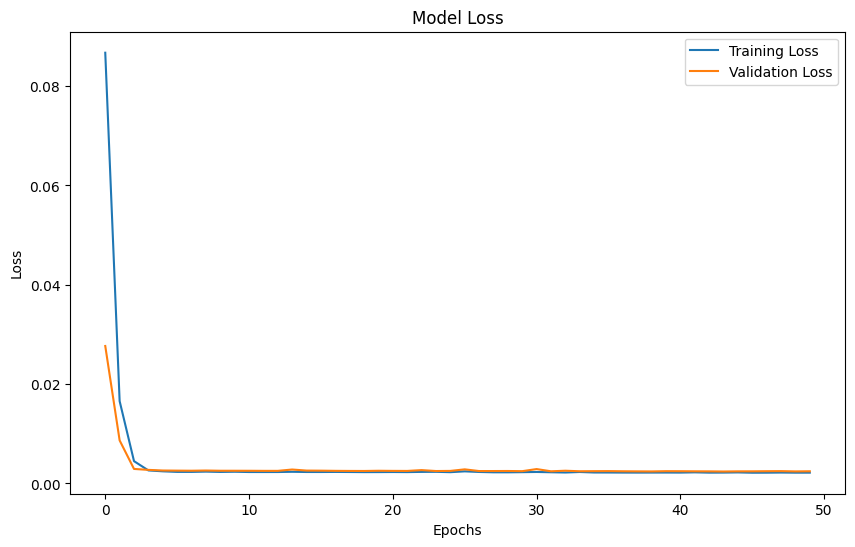

In [20]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
# Reconstruct the test data
X_test_pred = model.predict(X_test)
X_test_pred = X_test_pred.reshape(X_test_pred.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Calculate reconstruction error
reconstruction_errors = np.mean(np.abs(X_test - X_test_pred), axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step


In [22]:
# Set a threshold for anomalies
THRESHOLD = np.percentile(reconstruction_errors, 95)
print(f"Reconstruction error threshold: {THRESHOLD}")

# Detect anomalies
anomalies = reconstruction_errors > THRESHOLD
anomaly_indices = np.where(anomalies)[0]

Reconstruction error threshold: 0.043139181539865644


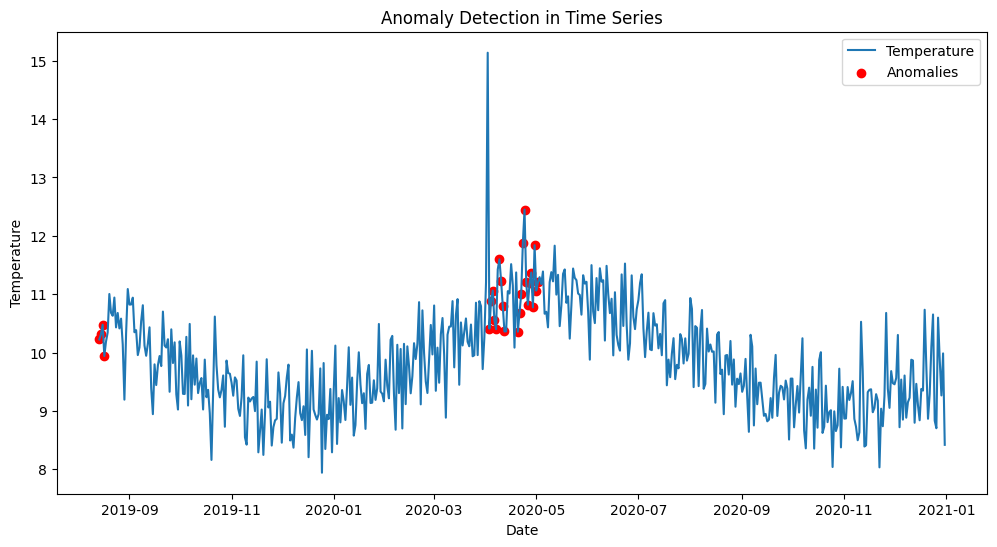

In [23]:
# Plot anomalies on the time series
anomaly_dates = df.index[TRAIN_SPLIT + TIME_STEPS:][anomaly_indices]
plt.figure(figsize=(12, 6))
plt.plot(df.index[TRAIN_SPLIT + TIME_STEPS:], scaler.inverse_transform(data_scaled[TRAIN_SPLIT + TIME_STEPS:]), label="Temperature")
plt.scatter(anomaly_dates, scaler.inverse_transform(data_scaled[TRAIN_SPLIT + TIME_STEPS:])[anomaly_indices], color='red', label="Anomalies")
plt.title("Anomaly Detection in Time Series")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.show()

Blue Line (Temperature):

* Represents the normalized temperature readings over time.
* It visualizes the fluctuations and general trends in your temperature data.

Red Dots (Anomalies):

* These are points identified as anomalies, meaning they significantly deviate from the expected pattern in the data.
* The detection is based on the reconstruction error, which measures how well the LSTM autoencoder could reconstruct the input sequences. If the reconstruction error exceeds the predefined threshold (set at the 95th percentile in your code), the point is marked as anomalous.

Clusters of Anomalies:

* The red dots tend to cluster around certain periods, such as early 2020 (March-May).
* These clusters might indicate systematic changes or unusual conditions during that time frame, such as:
** Temperature spikes/drops beyond the usual range.
** Data collection errors or other external factors affecting the temperature.

Thresholding:

* The anomalies are detected using a threshold. In this case, the threshold was calculated based on the 95th percentile of reconstruction errors. Points above this threshold are labeled as anomalies.